In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from torchsummary import summary
import glob
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN Encoder
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128), 
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.encoder(x)

# summary(CNNEncoder().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
            Conv2d-4         [-1, 64, 256, 256]          18,496
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
      BatchNorm2d-10        [-1, 128, 128, 128]             256
        MaxPool2d-11          [-1, 128, 64, 64]               0
Total params: 93,120
Trainable params: 93,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/ba

In [ ]:
# Dilated Residual Network (DRN)
class DRN(nn.Module):
    def __init__(self, dilation):
        super(DRN, self).__init__()
        self.conv = nn.Conv2d(128, 128, kernel_size=3, padding=dilation, dilation=dilation, bias=False)
        self.relu = nn.ReLU()
        self.BN = nn.BatchNorm2d(128)

    def forward(self, x):
        l1 = self.relu(self.BN(self.conv(x)))
        l1 = self.relu(self.BN(self.conv(l1)))
        return self.relu(self.BN(self.conv(l1) + x))  # Residual connection

# summary(DRN(1).to(device), (128, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]         147,456
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,456
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 64, 64]         147,456
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
Total params: 443,136
Trainable params: 443,136
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.00
Forward/backward pass size (MB): 36.00
Params size (MB): 1.69
Estimated Total Size (MB): 39.69
-----------------------------------------

In [ ]:
# Efficient Channel Attention (ECA)
class ECA(nn.Module):
    def __init__(self):
        super(ECA, self).__init__()
        self.conv = nn.Conv2d(128, 128, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(self.conv(x))

# summary(ECA().to(device), (128, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]          16,512
           Sigmoid-2          [-1, 128, 64, 64]               0
Total params: 16,512
Trainable params: 16,512
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 2.00
Forward/backward pass size (MB): 8.00
Params size (MB): 0.06
Estimated Total Size (MB): 10.06
----------------------------------------------------------------


In [ ]:
# Simple UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)

# summary(UNet().to(device), (256, 64, 64))

# Complete Model
class SARDespecklingNet(nn.Module):
    def __init__(self):
        super(SARDespecklingNet, self).__init__()
        self.encoder = CNNEncoder()
        self.drn1 = DRN(dilation=1)
        self.drn3 = DRN(dilation=3)
        self.drn5 = DRN(dilation=5)
        self.eca = ECA()
        self.unet = UNet()

    def forward(self, x):
        x = self.encoder(x)
        x1 = self.drn1(x)
        x3 = self.drn3(x)
        x5 = self.drn5(x)
        x = self.eca(x1 + x3 + x5)
        return self.unet(x)

# summary(SARDespecklingNet().to(device), (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
       BatchNorm2d-3         [-1, 32, 256, 256]              64
            Conv2d-4         [-1, 64, 256, 256]          18,496
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
      BatchNorm2d-10        [-1, 128, 128, 128]             256
        MaxPool2d-11          [-1, 128, 64, 64]               0
       CNNEncoder-12          [-1, 128, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]         147,456
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Dataset Placeholder (Assuming we have SAR Images & Clean Images)
def prepare_data(n):
    infiles = sorted(glob.glob('./s1/*.png'))[:n]
    outfiles = sorted(glob.glob('./s2/*.png'))[:n]
    in_data = []
    out_data = []

    for fi in infiles:
        img = cv2.imread(fi)
        img = cv2.resize(img, (256,256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        in_data.append(img)

    for fo in outfiles:
        img = cv2.imread(fo)
        img = cv2.resize(img, (256,256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        out_data.append(img)
    return in_data, out_data
    
class SARDataset(Dataset):
    def __init__(self, sar_images, clean_images, transform=None):
        self.sar_images = sar_images
        self.clean_images = clean_images
        self.transform = transform

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar = self.sar_images[idx]
        clean = self.clean_images[idx]
        # Remove or modify the transform application
        # if self.transform:
        #     sar = self.transform(sar)
        #     clean = self.transform(clean)
        return sar, clean



# Sample Data Preparation (Dummy Tensors)
dummy_sar, clean_sar = prepare_data(4000) # Corresponding clean images
dummy_sar = [np.array(img, dtype=np.float32) / 255 for img in dummy_sar]
clean_sar = [np.array(img, dtype=np.float32) / 255 for img in clean_sar]
dummy_sar = np.array(dummy_sar).reshape(-1, 1, 256, 256)
clean_sar = np.array(clean_sar).reshape(-1, 1, 256, 256)

# dummy_sar = dummy_sar.to(device)
# clean_sar = clean_sar.to(device)

# Remove the ToTensor transform or replace with a different transform if needed
# transform = transforms.ToTensor()

dataset = SARDataset(dummy_sar, clean_sar) #, transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
np.array(dummy_sar).shape

(50, 1, 256, 256)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(img1, img2):
    """
    Compute SSIM loss between two images.
    
    Args:
        img1: PyTorch tensor of shape [B, C, H, W]
        img2: PyTorch tensor of shape [B, C, H, W]

    Returns:
        Mean SSIM loss for batch
    """
    ssim_total = 0.0
    img1 = img1.detach().cpu().numpy()  # Convert to numpy
    img2 = img2.detach().cpu().numpy()
    
    for i in range(img1.shape[0]):  # Loop over batch
        for c in range(img1.shape[1]):  # Loop over channels
            ssim_val = ssim(img1[i, c], img2[i, c], data_range=img2[i, c].max() - img2[i, c].min())
            ssim_total += ssim_val

    return ssim_total / (img1.shape[0] * img1.shape[1])  # Normalize over batch and channels

def train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.001, alpha=0.85):
    """
    Trains the model using a combination of MSE and SSIM loss.

    Args:
        model: The SAR Despeckling model.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        epochs: Number of training epochs (default=10).
        lr: Learning rate (default=0.001).
        alpha: Weighting factor for combining MSE and SSIM (default=0.85).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    mse_loss = nn.MSELoss().to(device)  # MSE Loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4, factor=0.5, verbose=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for sar, clean in train_loader:
            sar, clean = sar.float().to(device), clean.float().to(device)
            optimizer.zero_grad()

            # Forward Pass
            output = model(sar)

            # Compute MSE
            mse = mse_loss(output, clean)

            # Compute SSIM
            ssim_value = calculate_ssim(output, clean)
            ssim_loss = 1 - ssim_value  # SSIM returns similarity, so (1 - SSIM) is the loss

            # Combined Loss
            loss = alpha * mse + (1 - alpha) * ssim_loss

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss/len(train_loader)}")

        # Evaluation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sar, clean in val_loader:
                sar, clean = sar.to(device, non_blocking=True), clean.to(device, non_blocking=True)
                output = model(sar)

                mse = mse_loss(output, clean)
                ssim_value = calculate_ssim(output, clean)
                ssim_loss = 1 - ssim_value
                loss = alpha * mse + (1 - alpha) * ssim_loss
                val_loss += loss.item()

        print(f"Validation Loss: {val_loss/len(val_loader)}")

        scheduler.step(val_loss/len(val_loader))
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        
        print(f"Updated Learning Rate: {current_lr}")

        if epoch % 2 == 0:
            torch.save(model, "./sar_model.pth")

# Train the model
model = SARDespecklingNet()
# model = torch.load("./sar_model.pth", map_location=torch.device('cpu'))
train_and_evaluate(model, train_loader, val_loader, epochs=1, lr=0.0001)


C:\Users\Viraj\Desktop\Project\SAR Despeckling\sarenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1, Training Loss: 2.1725820004940033
Validation Loss: 0.18910159915685654
Updated Learning Rate: 0.0001


In [ ]:
# # Training and Evaluation
# def train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.001):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
#     criterion = nn.MSELoss().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=lr)


#     for epoch in range(epochs):
#         model.train()
#         train_loss = 0

#         # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))
#         for sar, clean in train_loader:
#             sar, clean = sar.float().to(device), clean.float().to(device)
#             optimizer.zero_grad()
#             output = model(sar)
#             loss = criterion(output, clean)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss/len(train_loader)}")
        
#         if (epoch%2 == 0):
#             torch.save(model, "./sar_model.pth")
            
#         # Evaluation
#         model.eval()
#         val_loss = 0
#         with torch.no_grad():
#             for sar, clean in val_loader:
#                 sar, clean = sar.to(device, non_blocking=True), clean.to(device, non_blocking=True)
#                 output = model(sar)
#                 loss = criterion(output, clean)
#                 val_loss += loss.item()

#         print(f"Validation Loss: {val_loss/len(val_loader)}")


# # Train the model
# # model = SARDespecklingNet()
# model = torch.load("./sar_model.pth", weights_only=False, map_location=torch.device('cpu'))
# # train_and_evaluate(model, train_loader, val_loader, epochs=10, lr=0.0001)


In [30]:
x = torch.from_numpy(dummy_sar[:10]).float().to(device)
# x = x.reshape(1, -1, 256, 256)
x.shape

torch.Size([10, 1, 256, 256])

In [31]:
# model = torch.load("./sar_model.pth", weights_only=False)
model.eval()
with torch.no_grad():
    p = model(x).to(device)

print(p.shape)

torch.Size([10, 1, 256, 256])


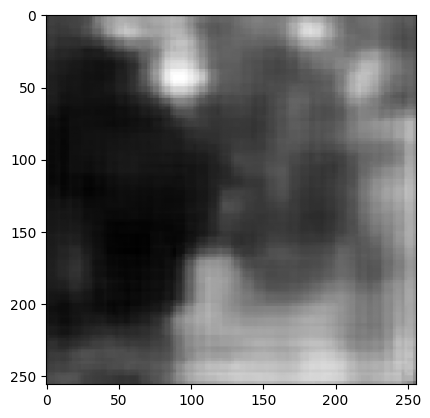

In [32]:
plt.imshow(p[5].reshape(256, 256), cmap='gray')

In [33]:
def compute_enl(image):
    """
    ENL measures speckle noise reduction in homogeneous regions.
    Higher ENL means better despeckling.
    """
    mean_val = np.mean(image)
    var_val = np.var(image)
    return (mean_val ** 2) / var_val if var_val != 0 else 0

# Evaluate despeckling performance
def evaluate_despeckling(original, despeckled):
    """
    Compute PSNR, SSIM, and ENL between the original and despeckled SAR images.
    """
    psnr_value = psnr(original, despeckled, data_range=original.max() - original.min())
    ssim_value = ssim(original, despeckled, data_range=original.max() - original.min())
    
    enl_original = compute_enl(original)
    enl_despeckled = compute_enl(despeckled)
    
    return {
        "PSNR": psnr_value,
        "SSIM": ssim_value,
        "ENL_Original": enl_original,
        "ENL_Despeckled": enl_despeckled
    }

In [61]:
metrics = evaluate_despeckling(clean_sar[:10].astype(np.float32).reshape(-1, 256, 256), p.numpy().reshape(-1, 256, 256).astype(np.float32))

In [62]:
metrics

{'PSNR': np.float64(14.507441206643879),
 'SSIM': np.float64(0.4848568576008796),
 'ENL_Original': np.float32(2.4778244),
 'ENL_Despeckled': np.float32(6.49)}